In [0]:
# Basic imports.
import os
import numpy as np
import torch
import time
import random
from tqdm import tqdm

from torch import nn
from torch import optim

from torch.utils.data import DataLoader
from torch.utils import data
from torch.backends import cudnn
from torch.autograd import Variable

from torchvision import models
from torchvision import datasets
from torchvision import transforms

from skimage import io

from sklearn import metrics

from matplotlib import pyplot as plt

%matplotlib inline

cudnn.benchmark = True

In [49]:
# Setting predefined arguments.
args = {
    'epoch_num': 50,      # Number of epochs.
    'n_classes': 10,      # Number of classes.
    'lr': 1e-3,           # Learning rate.
    'weight_decay': 5e-4, # L2 penalty.
    'momentum': 0.9,      # Momentum.
    'num_workers': 3,     # Number of workers on data loader.
    'batch_size': 30,     # Mini-batch size.
    'visibility': 0.75
}

if torch.cuda.is_available():
    args['device'] = torch.device('cuda')
else:
    args['device'] = torch.device('cpu')

print(args['device'])

cuda


In [4]:
root = './'

# Setting dataloader.
data_transform = transforms.Compose([
    transforms.ToTensor(),
])

train_set = datasets.MNIST(root,
                             train=True,
                             download=True,
                             transform=data_transform)
test_set = datasets.MNIST(root,
                            train=False,
                            download=False,
                            transform=data_transform)

train_loader = DataLoader(train_set,
                          args['batch_size'],
                          num_workers=args['num_workers'],
                          shuffle=True)
test_loader = DataLoader(test_set,
                         args['batch_size'],
                         num_workers=args['num_workers'],
                         shuffle=False)

print('Size of training set: ' + str(len(train_set)) + ' samples')
print('Size of test set: ' + str(len(test_set)) + ' samples')

Size of training set: 60000 samples
Size of test set: 10000 samples


# Atividade Prática

## Classificação MNIST

Implemente um modelo recorrente capaz de realizar classificação de imagens. Considere as imagens do MNIST, de dimensionalidade $28 \times 28$. Para criar um modelo de sequência poderíamos por exemplo criar uma sequência de $784$ elementos (pixels), ou poderíamos fazer a correlação de múltiplos recortes da imagem. 

A figura a seguir apresenta uma proposta de modelo recorrente para que você implemente e otimize para classificação de dígitos. Por se tratar de um dataset conhecido, e uma arquitetura conhecida, a atividade de hoje não trará instruções. Sinta-se livre para construir a rede proposta a seguir, ou variações dela. 

![](https://drive.google.com/uc?export=view&id=1fQcVWO3FzQ7m6iFmsnbmHe42bqCZi4S2)


In [146]:
class RecurrentNet(nn.Module):
  
  def __init__(self, in_size, hidden_size, num_classes, num_layers=2):
    super(RecurrentNet, self).__init__()
  
    self.hidden_size = hidden_size
    self.num_layers  = num_layers
    self.directions  = 2
    
    self.rnn = nn.GRU(in_size, hidden_size, num_layers=num_layers, bidirectional=True, batch_first=True)
    
    self.linear = nn.Linear(hidden_size*2, num_classes)
    self.activation = nn.Softmax()
  
  
  def forward(self, x):
    
    hs = torch.zeros(self.num_layers * self.directions, x.size(0), self.hidden_size ).to(args['device'])
    
    x = x.view(x.size(0), x.size(2), x.size(3))
    out, hs = self.rnn(x, hs)
    
    hidden_cat = torch.cat((hs[0], hs[1]), dim=-1)
    output  = self.activation( self.linear(hidden_cat) )
    
    return output

input_size  = 28
hidden_size = 64
num_classes = 10
num_layers  = 2
model_rnn = RecurrentNet(input_size, hidden_size, num_classes, num_layers).to(args['device'])

model_parameters = filter(lambda p: p.requires_grad, model_rnn.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print('Total de %d parametros'%params)

Total de 111882 parametros


In [0]:
optimizer = optim.Adam(model_rnn.parameters(),
                       lr=args['lr'],
                       betas=(args['momentum'], 0.999),
                       weight_decay=args['weight_decay'])

criterion = nn.CrossEntropyLoss().to(args['device'])

In [0]:
def train(train_loader, net, criterion, optimizer, epoch):

    # Setting network for training mode.
    net.train()

    # Lists for losses and metrics.
    train_loss = []
    
    begin = time.time()
    
    # Iterating over batches.
    for i, batch_data in enumerate(train_loader):

        # Obtaining images, labels and paths for batch.
        inps, labs = batch_data
        
        # Casting to cuda variables.
        inps = inps.to(args['device'])
        labs = labs.to(args['device'])
        
        # Clears the gradients of optimizer.
        optimizer.zero_grad()

        # Forwarding.
        outs = net(inps)

        # Computing loss.
        loss = criterion(outs, labs)

        # Computing backpropagation.
        loss.backward()
        optimizer.step()
        
        # Updating lists.
        train_loss.append(loss.data.item())
    
    end = time.time()
    
    train_loss = np.asarray(train_loss)
    
    # Printing training epoch loss and metrics.
    print('--------------------------------------------------------------------')
    print('[epoch %d], [train loss %.4f +/- %.4f | Time: %.2f ]' % (
        epoch, train_loss.mean(), train_loss.std(), end-begin))
    print('--------------------------------------------------------------------')
        
    return train_loss.mean(), end-begin
    
    
def test(test_loader, net, criterion, epoch):

    # Setting network for evaluation mode.
    net.eval()

    # Lists for losses and metrics.
    test_loss = []
    prd_list = []
    lab_list = []
    
    begin = time.time()
    
    # Iterating over batches.
    for i, batch_data in enumerate(train_loader):

        # Obtaining images, labels and paths for batch.
        inps, labs = batch_data

        # Casting to cuda variables.
        inps = inps.to(args['device'])
        labs = labs.to(args['device'])

        # Forwarding.
        outs = net(inps)

        # Computing loss.
        loss = criterion(outs, labs)
        
        # Obtaining predictions.
        prds = outs.data.max(dim=1)[1].cpu().numpy()
        
        # Updating lists.
        test_loss.append(loss.data.item())
        prd_list.append(prds)
        lab_list.append(labs.detach().cpu().numpy())
    
    end = time.time()
    
    # Computing accuracy.
    acc = metrics.accuracy_score(np.asarray(lab_list).ravel(),
                                 np.asarray(prd_list).ravel())
    
    test_loss = np.asarray(test_loss)
    
    # Printing training epoch loss and metrics.
    print('--------------------------------------------------------------------')
    print('[epoch %d], [test loss %.4f +/- %.4f | Time: %.2f], [acc %.4f]' % (
        epoch, test_loss.mean(), test_loss.std(), end-begin, acc))
    print('--------------------------------------------------------------------')
    
    return test_loss.mean(), end-begin, acc

In [75]:
# Iterating over epochs.
for epoch in range(1, args['epoch_num'] + 1):

    # Training function.
    trloss, trtime = train(train_loader, model_rnn, criterion, optimizer, epoch)

    # Computing test loss and metrics.
    tsloss, tstime, tsacc = test(test_loader, model_rnn, criterion, epoch)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


--------------------------------------------------------------------
[epoch 1], [train loss 1.7608 +/- 0.1645]
--------------------------------------------------------------------
--------------------------------------------------------------------
[epoch 1], [test loss 1.6018 +/- 0.0653], [acc 0.8723]
--------------------------------------------------------------------
--------------------------------------------------------------------
[epoch 2], [train loss 1.5566 +/- 0.0609]
--------------------------------------------------------------------
--------------------------------------------------------------------
[epoch 2], [test loss 1.5267 +/- 0.0471], [acc 0.9416]
--------------------------------------------------------------------
--------------------------------------------------------------------
[epoch 3], [train loss 1.5218 +/- 0.0462]
--------------------------------------------------------------------
--------------------------------------------------------------------
[epoc

KeyboardInterrupt: ignored

# Atividade Prática II

## Pixel RNN

Também é possível trabalhar de forma auto-supervisionada usando modelos recorrentes. Um exemplo de destaque é a PixelRNN, que considera cada pixel da imagem como uma unidade de sequência, e propõe um modelo probabilístico para prever o próximo pixel, dada uma sequência de pixels antecessores. A imagem a seguir ilustra essa proposta.
* Paper: https://arxiv.org/abs/1601.06759

<img src="https://drive.google.com/uc?export=view&id=198yw7kilta27G_bx3Ldcjguor_-qkk97" width="250"><br><br>

A melhor configuração dentre as propostas no artigo foi capaz de preencher lacunas em imagens com oclusões artificiais. Note que é preciso alimentar o modelo com uma porção significativa da imagem para que ele seja capaz de prever o restante.

<img src="https://miro.medium.com/max/700/0*o7PUa9K5rPGeFIcx." width="600"><br><br>



Uma modelagem simples para esse problema, se parece com o que aprendemos na aula de geração de sequências (seq2seq), porém não existe a etapa de codificação, apenas a decodificação do valor seguinte a partir do valor atual.

* Entrada: vetor linearizado e com a oclusão artificial ```(batch_size, 784, 1)```. A oclusão ocorre através do preenchimento com zeros em uma região fixa da imagem. O parâmetro ```args['visibility']``` determina o percentual da imagem visível para a rede.
* Saída esperada: dígito reconstruído extrapolando a oclusão. Para isso, o cálculo da loss é realizado comparando a reconstrução com o dado **original**. ```(batch_size, 784, 1)```

Nota: Para essa aplicação não faremos distinção entre o forward de treinamento e de inferência. 

![](https://drive.google.com/uc?export=view&id=1DzHtZXT1dsWm4s7xbZfmu0NiLmKw7jpL)

In [0]:
class Seq2Seq(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(Seq2Seq, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers

        self.gru = nn.GRU(self.input_size, self.hidden_size, num_layers=self.num_layers, batch_first=True)
        self.out = nn.Linear(self.hidden_size, self.output_size)
        self.activation = nn.Sigmoid()

    def forward(self, targets):

        targets = targets.view(targets.size(0), -1).unsqueeze(-1).float()

        hidden = torch.zeros(self.num_layers, targets.size(0), self.hidden_size).to(args['device'])
              
        output_rnn, hidden = self.gru(targets, hidden)
        output = output_rnn.contiguous().view(output_rnn.size(0)*output_rnn.size(1), output_rnn.size(2))
        output = self.activation(self.out(output))
        output = output.view(output_rnn.size(0), output_rnn.size(1), -1)
        
        return output
      

input_size  = 1
hidden_size = 128
output_size = 1 

pixelrnn = Seq2Seq(input_size, hidden_size, output_size).to(args['device'])


In [0]:
optimizer = optim.Adam(pixelrnn.parameters(),
                       lr=args['lr'],
                       betas=(args['momentum'], 0.999),
                       weight_decay=args['weight_decay'])

criterion = nn.MSELoss().to(args['device'])

In [0]:
def train(train_loader, net, criterion, optimizer, epoch):

    # Setting network for training mode.
    net.train()

    # Lists for losses and metrics.
    train_loss = []
    
    begin = time.time()
    
    # Iterating over batches.
    for i, batch_data in enumerate(train_loader):
        if i > 501: break  

        # Obtaining images, labels and paths for batch.
        inps, _ = batch_data
        labs = inps.view(inps.size(0),-1).unsqueeze(-1)
        
        
        # Casting to cuda variables.
        inps = inps.to(args['device'])
        labs = labs.to(args['device'])
        
        patch_occ = int(args['visibility'] * 784) 
        input_occ = torch.zeros(labs.size()).to(args['device'])
        input_occ[:,:patch_occ] = labs[:, :patch_occ]
        
        # Clears the gradients of optimizer.
        optimizer.zero_grad()

        # Forwarding.
        outs = net(input_occ[:,:-1])

        # Computing loss.
        loss = 0.
        for k, out in enumerate(outs):
          loss += criterion(out, labs[k, 1:])
        
        # Computing backpropagation.
        loss.backward()
        optimizer.step()
        
        # Plot prediction
        prds = np.append(np.zeros( (len(outs),1,1) ), outs.detach().data.cpu().numpy(), axis=1)
        if i % 250 == 1:
          print(loss)
          fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10,5))
          
          img_label = labs[0].detach().data.cpu().numpy().reshape(inps.size(2), inps.size(3))
          axs[0].imshow(img_label)
          axs[0].set_title('Ground Truth')
          
          img_label = input_occ[0].detach().data.cpu().numpy().reshape(inps.size(2), inps.size(3))
          axs[1].imshow(img_label)
          axs[1].set_title('Input (Occlusion)')
          
          img = prds.reshape(inps.size(0), inps.size(2), inps.size(3))[0]
          axs[2].imshow(img)
          axs[2].set_title('Prediction')
          
          plt.show()
          plt.close(fig)
          
        
        # Updating lists.
        train_loss.append(loss.data.item())
    
    end = time.time()
    
    train_loss = np.asarray(train_loss)
    
    # Printing training epoch loss and metrics.
    print('--------------------------------------------------------------------')
    print('[epoch %d], [train loss %.4f +/- %.4f | Time: %.2f ]' % (
        epoch, train_loss.mean(), train_loss.std(), end-begin))
    print('--------------------------------------------------------------------')
        
    return train_loss.mean(), end-begin
    
    
def test(test_loader, net, criterion, epoch):

    # Setting network for evaluation mode.
    net.eval()

    # Lists for losses and metrics.
    test_loss = []
    prd_list = []
    lab_list = []
    
    begin = time.time()
    
    # Iterating over batches.
    for i, batch_data in enumerate(train_loader):
        if i > 401: break

        # Obtaining images, labels and paths for batch.
        inps, _ = batch_data
        labs = inps.view(inps.size(0),-1).unsqueeze(-1)

        # Casting to cuda variables.
        inps = inps.to(args['device'])
        labs = labs.to(args['device'])
        
        patch_occ = int(args['visibility'] * 784) 
        input_occ = torch.zeros(labs.size()).to(args['device'])
        input_occ[:,:patch_occ] = labs[:, :patch_occ]

        # Forwarding.
        outs = net(labs[:, :-1])

        # Plot prediction
        prds = np.append(np.zeros( (len(outs),1,1) ), outs.detach().data.cpu().numpy(), axis=1)
        if i % 250 == 1:
          print(loss)
          fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10,5))
          
          img_label = labs[0].detach().data.cpu().numpy().reshape(inps.size(2), inps.size(3))
          axs[0].imshow(img_label)
          axs[0].set_title('Ground Truth')
          
          img_label = input_occ[0].detach().data.cpu().numpy().reshape(inps.size(2), inps.size(3))
          axs[1].imshow(img_label)
          axs[1].set_title('Input (Occlusion)')
          
          img = prds.reshape(inps.size(0), inps.size(2), inps.size(3))[0]
          axs[2].imshow(img)
          axs[2].set_title('Prediction')
          
          plt.show()
          plt.close(fig)
        
        # Computing loss.
        loss = 0.
        for k, out in enumerate(outs):
          loss += criterion(out, labs[k, 1:])
        
        # Obtaining predictions.
        prds = outs.data.max(dim=1)[1].cpu().numpy()
        
        # Updating lists.
        test_loss.append(loss.data.item())
        prd_list.append(prds)
        lab_list.append(labs.detach().cpu().numpy())
        
    end = time.time()
    
    # Computing accuracy.
    
    test_loss = np.asarray(test_loss)
    
    # Printing training epoch loss and metrics.
    print('--------------------------------------------------------------------')
    print('[epoch %d], [test loss %.4f +/- %.4f | Time: %.2f]' % (
        epoch, test_loss.mean(), test_loss.std(), end-begin))
    print('--------------------------------------------------------------------')
    
    return test_loss.mean(), end-begin

tensor(7.0615, device='cuda:0', grad_fn=<AddBackward0>)


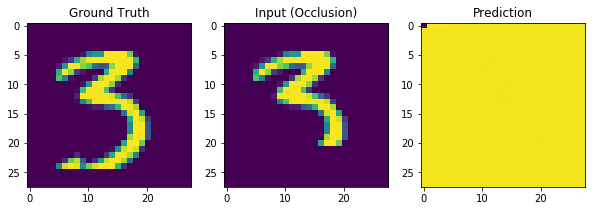

tensor(1.2398, device='cuda:0', grad_fn=<AddBackward0>)


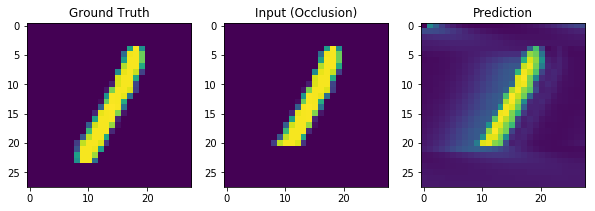

tensor(0.8016, device='cuda:0', grad_fn=<AddBackward0>)


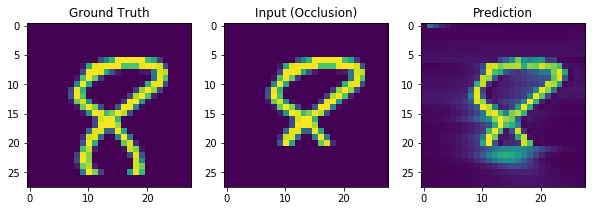

--------------------------------------------------------------------
[epoch 1], [train loss 1.5864 +/- 0.9556 | Time: 54.86 ]
--------------------------------------------------------------------
tensor(0.6906, device='cuda:0', grad_fn=<AddBackward0>)


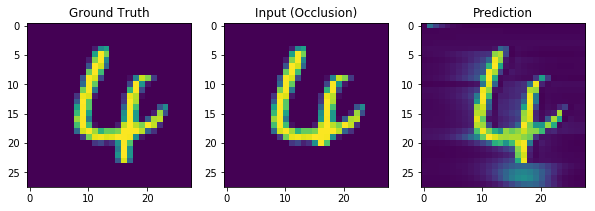

tensor(0.7268, device='cuda:0', grad_fn=<AddBackward0>)


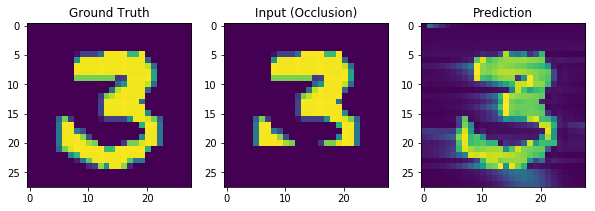

--------------------------------------------------------------------
[epoch 1], [test loss 0.7285 +/- 0.0296 | Time: 21.72]
--------------------------------------------------------------------
tensor(0.7282, device='cuda:0', grad_fn=<AddBackward0>)


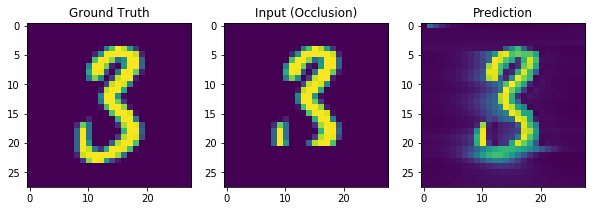

tensor(0.7717, device='cuda:0', grad_fn=<AddBackward0>)


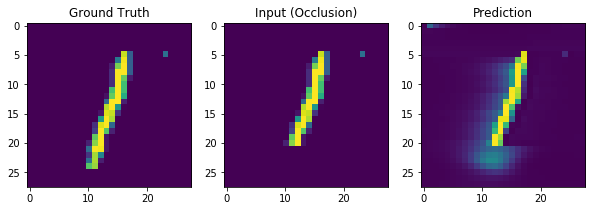

tensor(0.6260, device='cuda:0', grad_fn=<AddBackward0>)


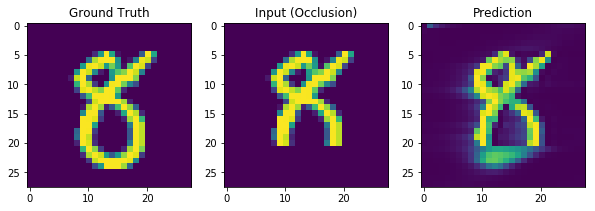

--------------------------------------------------------------------
[epoch 2], [train loss 0.7158 +/- 0.0579 | Time: 54.98 ]
--------------------------------------------------------------------
tensor(0.5165, device='cuda:0', grad_fn=<AddBackward0>)


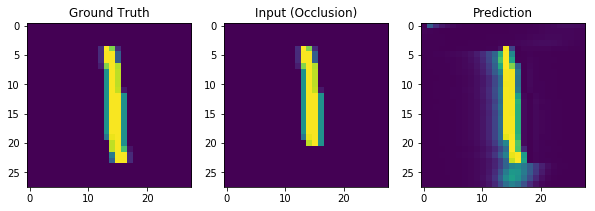

tensor(0.5541, device='cuda:0', grad_fn=<AddBackward0>)


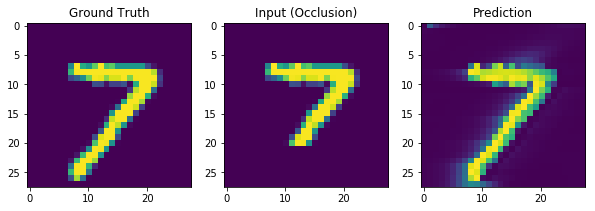

--------------------------------------------------------------------
[epoch 2], [test loss 0.5683 +/- 0.0291 | Time: 22.09]
--------------------------------------------------------------------
tensor(0.7105, device='cuda:0', grad_fn=<AddBackward0>)


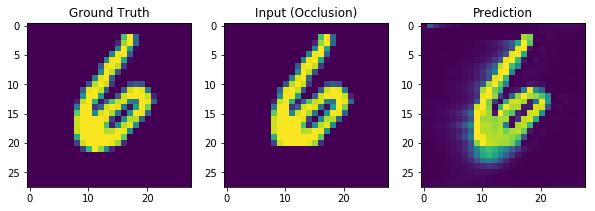

tensor(0.6297, device='cuda:0', grad_fn=<AddBackward0>)


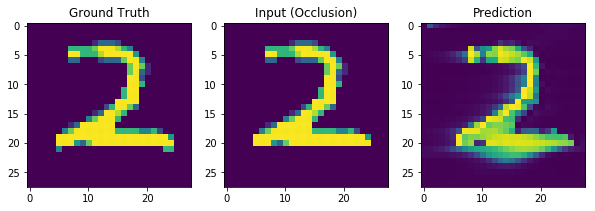

tensor(0.5117, device='cuda:0', grad_fn=<AddBackward0>)


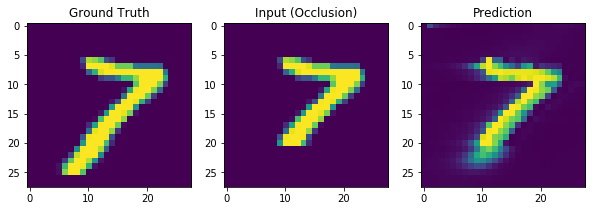

--------------------------------------------------------------------
[epoch 3], [train loss 0.6208 +/- 0.0476 | Time: 54.74 ]
--------------------------------------------------------------------
tensor(0.4522, device='cuda:0', grad_fn=<AddBackward0>)


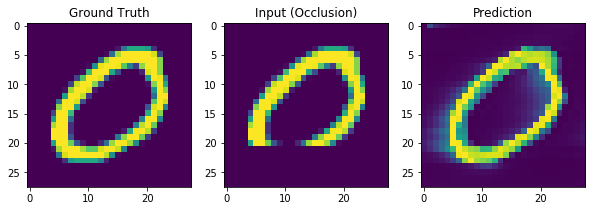

tensor(0.4993, device='cuda:0', grad_fn=<AddBackward0>)


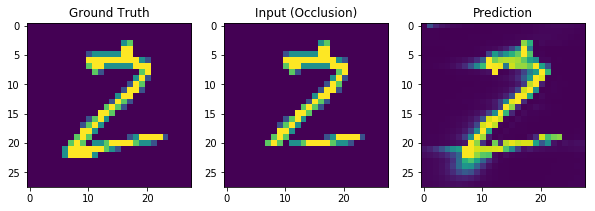

--------------------------------------------------------------------
[epoch 3], [test loss 0.4870 +/- 0.0289 | Time: 21.88]
--------------------------------------------------------------------
tensor(0.6253, device='cuda:0', grad_fn=<AddBackward0>)


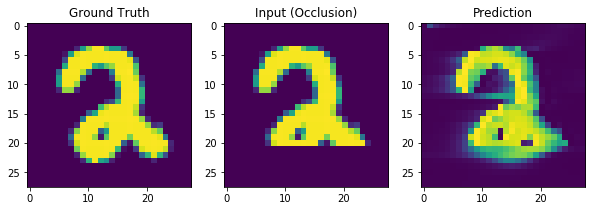

tensor(0.4683, device='cuda:0', grad_fn=<AddBackward0>)


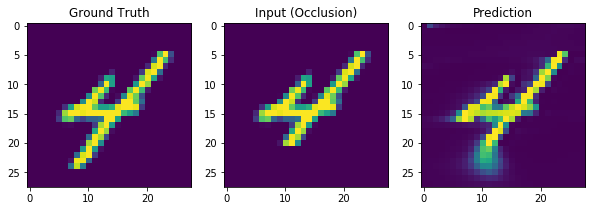

tensor(0.4072, device='cuda:0', grad_fn=<AddBackward0>)


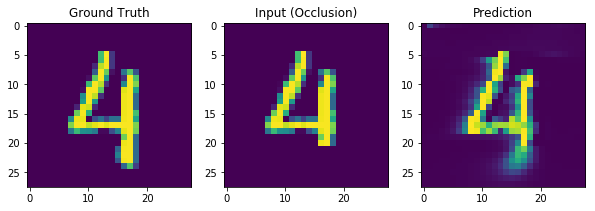

--------------------------------------------------------------------
[epoch 4], [train loss 0.5187 +/- 0.0457 | Time: 55.30 ]
--------------------------------------------------------------------
tensor(0.4250, device='cuda:0', grad_fn=<AddBackward0>)


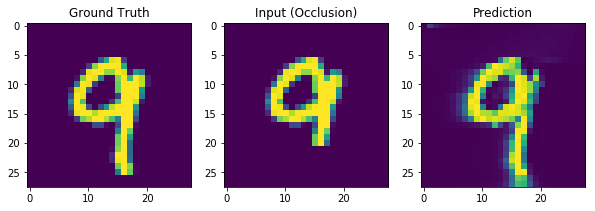

tensor(0.4555, device='cuda:0', grad_fn=<AddBackward0>)


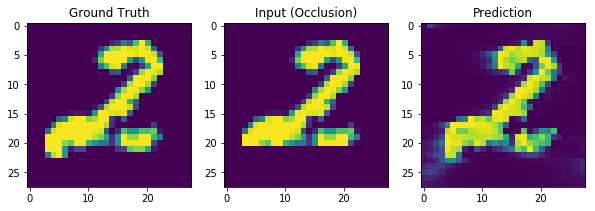

--------------------------------------------------------------------
[epoch 4], [test loss 0.4317 +/- 0.0241 | Time: 22.08]
--------------------------------------------------------------------
tensor(0.4850, device='cuda:0', grad_fn=<AddBackward0>)


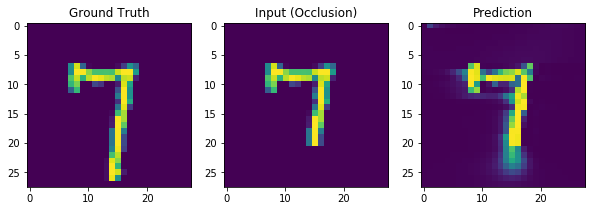

tensor(0.4632, device='cuda:0', grad_fn=<AddBackward0>)


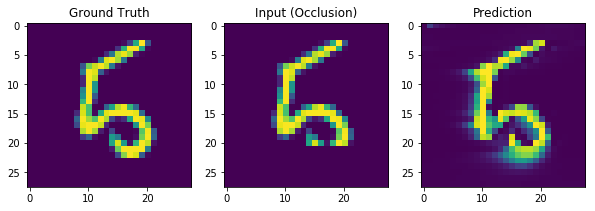

tensor(0.5128, device='cuda:0', grad_fn=<AddBackward0>)


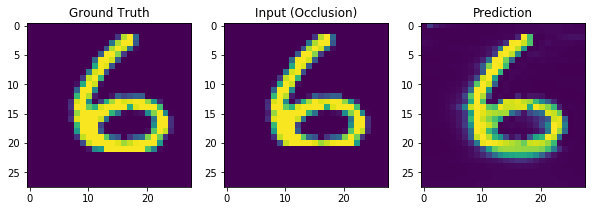

--------------------------------------------------------------------
[epoch 5], [train loss 0.4608 +/- 0.0362 | Time: 54.73 ]
--------------------------------------------------------------------
tensor(0.4120, device='cuda:0', grad_fn=<AddBackward0>)


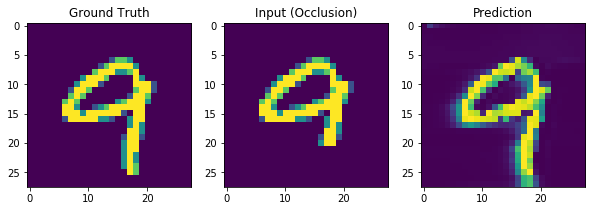

tensor(0.4475, device='cuda:0', grad_fn=<AddBackward0>)


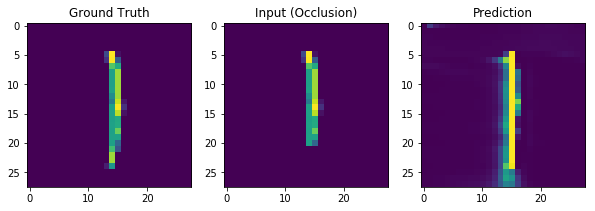

--------------------------------------------------------------------
[epoch 5], [test loss 0.3992 +/- 0.0233 | Time: 21.13]
--------------------------------------------------------------------
tensor(0.4373, device='cuda:0', grad_fn=<AddBackward0>)


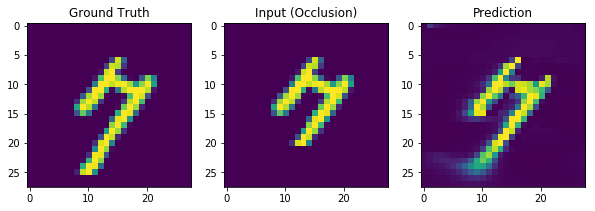

tensor(0.4304, device='cuda:0', grad_fn=<AddBackward0>)


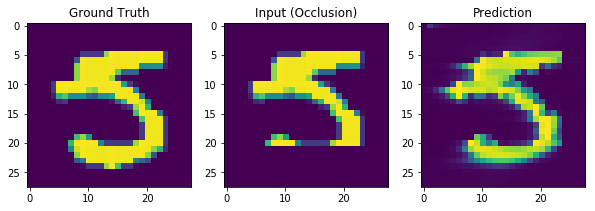

tensor(0.4951, device='cuda:0', grad_fn=<AddBackward0>)


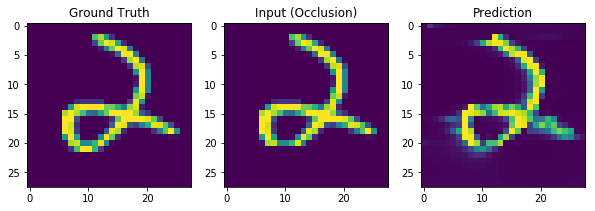

--------------------------------------------------------------------
[epoch 6], [train loss 0.4292 +/- 0.0327 | Time: 54.44 ]
--------------------------------------------------------------------
tensor(0.3565, device='cuda:0', grad_fn=<AddBackward0>)


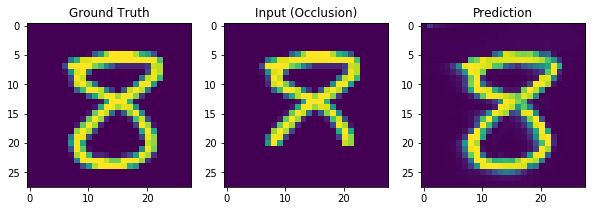

tensor(0.3555, device='cuda:0', grad_fn=<AddBackward0>)


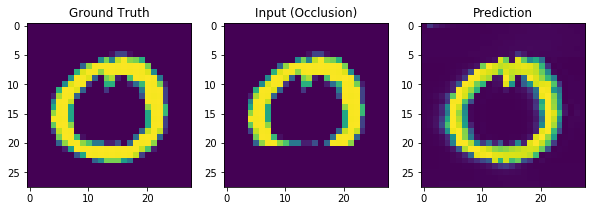

--------------------------------------------------------------------
[epoch 6], [test loss 0.3791 +/- 0.0226 | Time: 20.87]
--------------------------------------------------------------------
tensor(0.4175, device='cuda:0', grad_fn=<AddBackward0>)


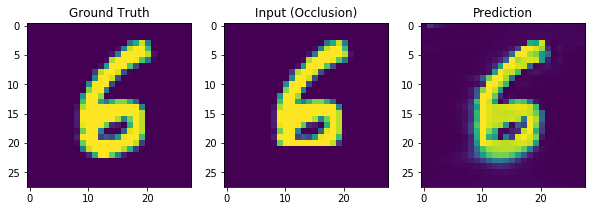

KeyboardInterrupt: ignored

In [371]:
# Iterating over epochs.
for epoch in range(1, args['epoch_num'] + 1):

#     Training function.
    train(train_loader, pixelrnn, criterion, optimizer, epoch)

    # Computing test loss and metrics.
    test(test_loader, pixelrnn, criterion, epoch)